# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [59]:
# !pip install emnist
# your pip installs here

### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [60]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

# Преобразования для тренировочных данных

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),  # Аугментация: случайный поворот
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),  # Преобразование в тензор
        # transforms.Lambda(lambda x: 1 - x), 
        transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
        transforms.Normalize((0.1736,), (0.3317,)),  # Нормализация
    ]
)

# Преобразования для тестовых данных
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Преобразование в тензор
        # transforms.Lambda(lambda x: 1 - x), 
        transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
        transforms.Normalize((0.1736,), (0.3317,)),  # Нормализация
    ]
)

# Загрузка набора EMNIST Balanced
train_dataset = datasets.EMNIST(
    root="./data",
    split="balanced",
    train=True,
    download=False,
    transform=train_transform,
)
test_dataset = datasets.EMNIST(
    root="./data",
    split="balanced",
    train=False,
    download=False,
    transform=test_transform,
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [61]:
# Доступ к изображениям и меткам
images_train, labels_train = train_dataset.data, train_dataset.targets
images_test, labels_test = test_dataset.data, test_dataset.targets

# Вывод информации о данных
print(f"Train: {images_train.shape[0]} images with size: {images_train.shape[1:]}")
print(f"Test: {images_test.shape[0]} images with size: {images_test.shape[1:]}")

Train: 112800 images with size: torch.Size([28, 28])
Test: 18800 images with size: torch.Size([28, 28])


Label  |  Symbol  |  Train samples qty
--------------------------------------------------
   10  |    A     |   2400
   11  |    B     |   2400
   12  |    C     |   2400
   13  |    D     |   2400
   14  |    E     |   2400
   15  |    F     |   2400
   16  |    G     |   2400
   17  |    H     |   2400
   18  |    I     |   2400
   19  |    J     |   2400


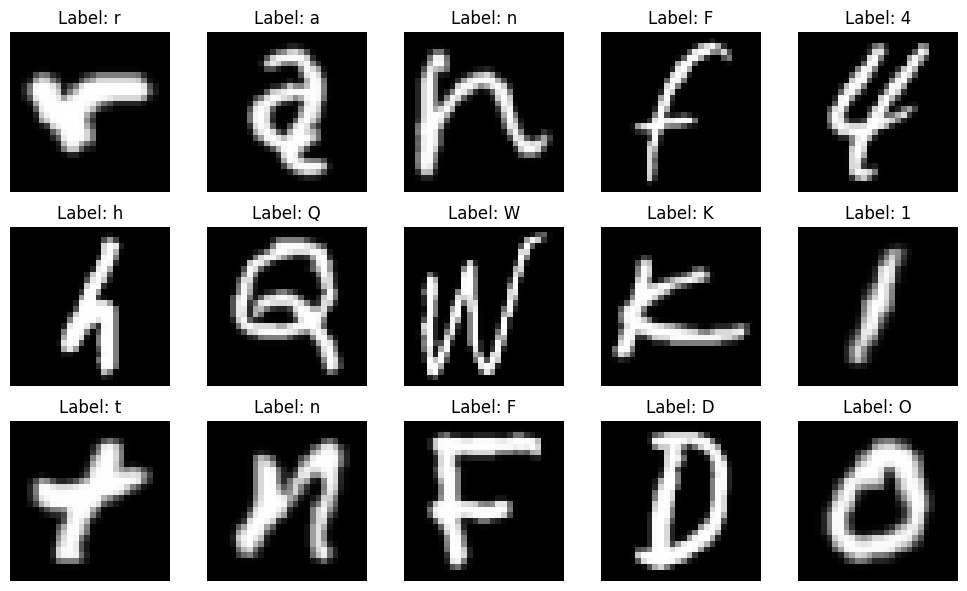

In [62]:
import matplotlib.pyplot as plt
import numpy as np


# Читаем файл с соответствием лейблов ASCII-кодам
mapping_path = "data/emnist-balanced-mapping.txt"
label_to_char = {}

with open(mapping_path, "r") as f:
    for line in f:
        label, ascii_code = map(int, line.split())
        label_to_char[label] = chr(ascii_code)

# Подсчитываем количество примеров для каждого лейбла
unique_labels, counts = np.unique(labels_train.numpy(), return_counts=True)

# Выводим соответствие лейблов символам и количество тренировочных примеров
print("Label  |  Symbol  |  Train samples qty")
print("-" * 50)
for label, count in zip(unique_labels[10:20], counts[10:20]):
    print(f"{label:5}  |    {label_to_char[label]}     |   {count}")


# Функция для корректного отображения изображений EMNIST
def emnist_visualize(image):
    image = np.transpose(image, (1, 0))  # Транспонирование (поворот на 90 градусов)
    # image = np.fliplr(image)  # Отражение по горизонтали
    return image


# Визуализация нескольких примеров изображений
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    corrected_image = emnist_visualize(images_train[i].numpy().squeeze())
    axes[i].imshow(corrected_image, cmap="gray")
    axes[i].set_title(f"Label: {label_to_char[labels_train[i].item()]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

In [63]:
# Проверка доступности CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [64]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Исправление: изменение размерности входных данных
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Автоматическое разворачивание
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Количество классов в EMNIST Balanced
num_classes = 47  # EMNIST Balanced содержит 47 классов

# Инициализация модели
model = SimpleCNN(num_classes).to(device)

In [65]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [66]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Перенос данных на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Печатаем каждые 100 мини-батчей
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}],"
                    f" \tStep [{i + 1}/{len(train_loader)}],"
                    f" \tLoss: {running_loss / 100:.4f}"
                )
                running_loss = 0.0

In [67]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Перенос данных на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy of the model on the test images: {acc:.2f}%')
    return acc

In [68]:
# Запуск обучения
train(model, train_loader, criterion, optimizer, num_epochs=5)

# Проверка точности модели
accuracy = test(model, test_loader)

Epoch [1/5], 	Step [100/1763], 	Loss: 2.6986
Epoch [1/5], 	Step [200/1763], 	Loss: 1.4030
Epoch [1/5], 	Step [300/1763], 	Loss: 1.0717
Epoch [1/5], 	Step [400/1763], 	Loss: 0.9549
Epoch [1/5], 	Step [500/1763], 	Loss: 0.8612
Epoch [1/5], 	Step [600/1763], 	Loss: 0.8470
Epoch [1/5], 	Step [700/1763], 	Loss: 0.7610
Epoch [1/5], 	Step [800/1763], 	Loss: 0.7077
Epoch [1/5], 	Step [900/1763], 	Loss: 0.7088
Epoch [1/5], 	Step [1000/1763], 	Loss: 0.6629
Epoch [1/5], 	Step [1100/1763], 	Loss: 0.6817
Epoch [1/5], 	Step [1200/1763], 	Loss: 0.6436
Epoch [1/5], 	Step [1300/1763], 	Loss: 0.6692
Epoch [1/5], 	Step [1400/1763], 	Loss: 0.6350
Epoch [1/5], 	Step [1500/1763], 	Loss: 0.6154
Epoch [1/5], 	Step [1600/1763], 	Loss: 0.5970
Epoch [1/5], 	Step [1700/1763], 	Loss: 0.6006
Epoch [2/5], 	Step [100/1763], 	Loss: 0.5510
Epoch [2/5], 	Step [200/1763], 	Loss: 0.5631
Epoch [2/5], 	Step [300/1763], 	Loss: 0.5684
Epoch [2/5], 	Step [400/1763], 	Loss: 0.5610
Epoch [2/5], 	Step [500/1763], 	Loss: 0.5535
Ep

In [69]:
from sklearn.metrics import confusion_matrix
import numpy as np

def get_confusion_matrix(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Создание матрицы ошибок
    cm = confusion_matrix(all_labels, all_predictions)
    return cm

# Получение матрицы ошибок
cm = get_confusion_matrix(model, test_loader, device)

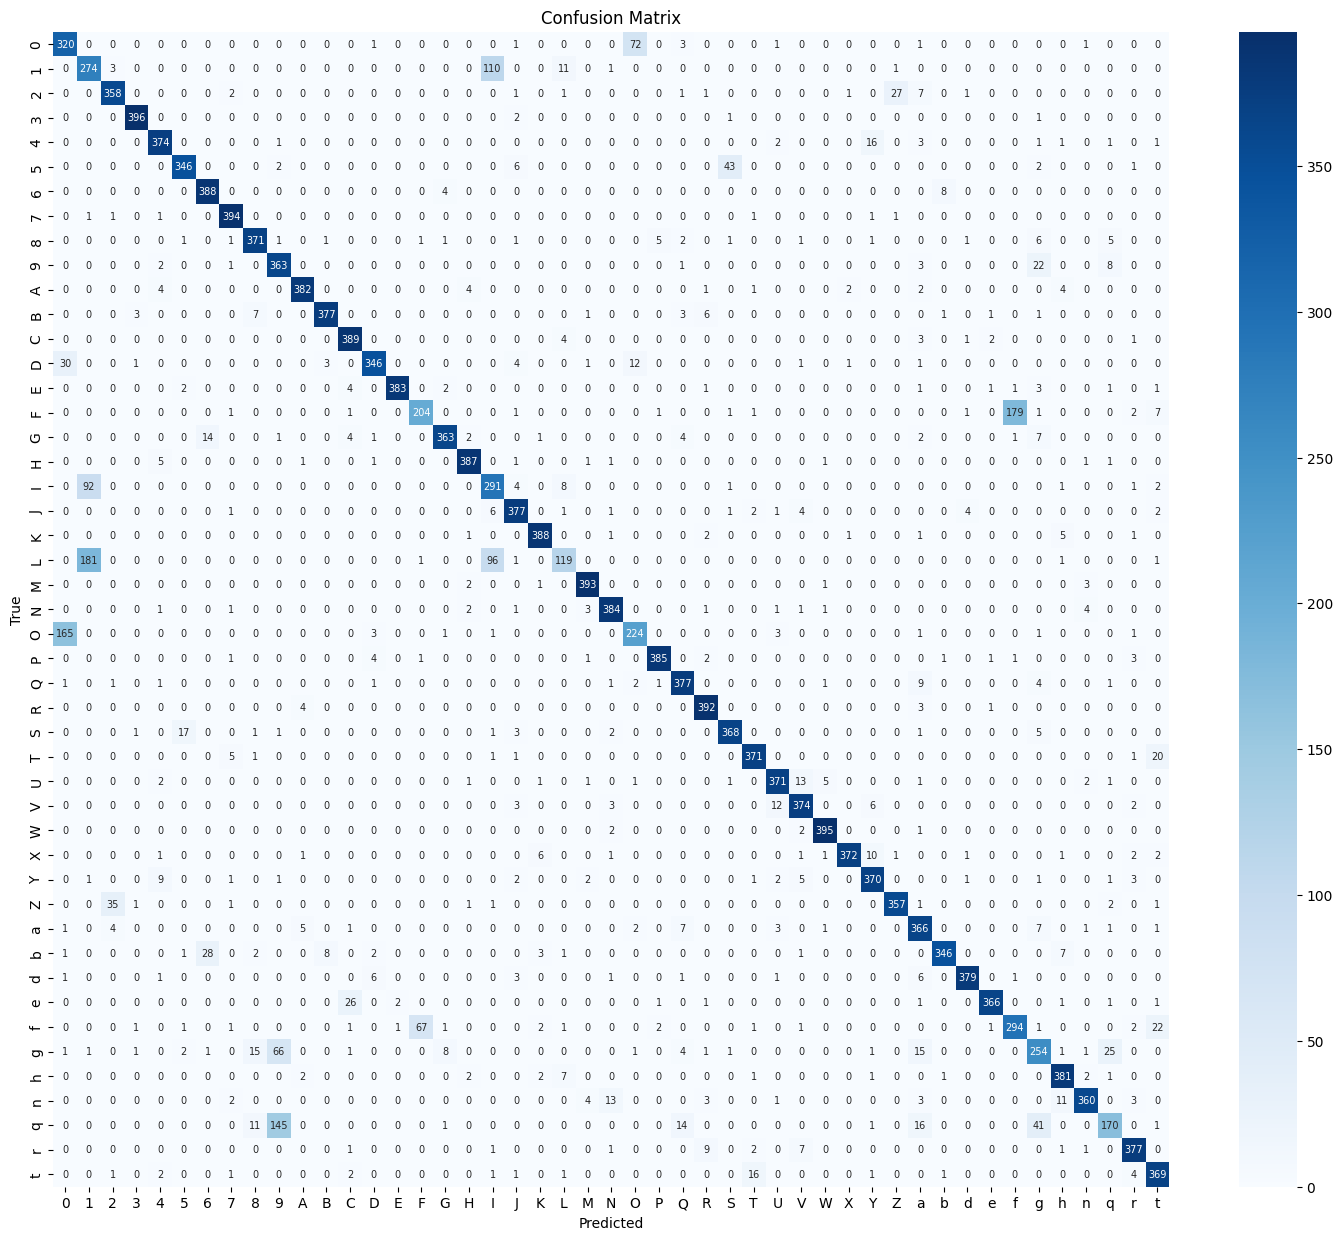

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(18, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 7})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show();

# Пример названий классов для EMNIST Balanced
# class_names = [str(i) for i in range(num_classes)]  # Замените на реальные названия классов, если они известны
class_names = label_to_char.values()
    
# Визуализация матрицы ошибок
plot_confusion_matrix(cm, class_names)

In [71]:
symbols = "".join(class_names)
symbols

'0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [72]:
def find_most_common_errors(cm, class_names):
    class_names = list(class_names)
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:  # Игнорируем диагональ и нулевые значения
                errors.append((class_names[i], class_names[j], cm[i, j]))
    
    # Сортировка по количеству ошибок
    errors.sort(key=lambda x: x[2], reverse=True)
    return errors

# Получение списка наиболее частых ошибок
common_errors = find_most_common_errors(cm, class_names)

# Вывод топ-10 ошибок
for true_label, predicted_label, count in common_errors[:20]:
    print(f'True: {true_label:<2} -  Predicted: {predicted_label:<2} -  Count: {count}')

True: L  -  Predicted: 1  -  Count: 181
True: F  -  Predicted: f  -  Count: 179
True: O  -  Predicted: 0  -  Count: 165
True: q  -  Predicted: 9  -  Count: 145
True: 1  -  Predicted: I  -  Count: 110
True: L  -  Predicted: I  -  Count: 96
True: I  -  Predicted: 1  -  Count: 92
True: 0  -  Predicted: O  -  Count: 72
True: f  -  Predicted: F  -  Count: 67
True: g  -  Predicted: 9  -  Count: 66
True: 5  -  Predicted: S  -  Count: 43
True: q  -  Predicted: g  -  Count: 41
True: Z  -  Predicted: 2  -  Count: 35
True: D  -  Predicted: 0  -  Count: 30
True: b  -  Predicted: 6  -  Count: 28
True: 2  -  Predicted: Z  -  Count: 27
True: e  -  Predicted: C  -  Count: 26
True: g  -  Predicted: q  -  Count: 25
True: 9  -  Predicted: g  -  Count: 22
True: f  -  Predicted: t  -  Count: 22


In [73]:
metadata = {
    'model_name': type(model).__name__,
    'num_classes': num_classes,
    'epochs_trained': 5,
    'optimizer_state': optimizer.state_dict(),
    'loss': 'CrossEntropyLoss',
    'dataset': 'EMNIST Balanced',
    'description': 'EMNIST symbol classification model',
    'version': '1.0',
    'accuracy': accuracy,
}

# Сохраняем модель и метаданные в один файл
torch.save({
    'model_state_dict': model.state_dict(),  # Сохраняем параметры модели
    'metadata': metadata                    # Сохраняем метаданные
}, 'model/EMNIST_CNN.pth')